In [2]:

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
import torch
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import cv2

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


### 1. Insert Saved *.pt Model here:

In [4]:
model = torch.load('apple_vit_classifier.pt')

### 2. Insert image location of the apple:

In [5]:
image_url = 'myapple_5.jpg'
img = cv2.imread(image_url)

In [6]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [7]:
# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Ensure that the model's weight tensor is on the same device as the input tensor
model.to(device)
model.eval()


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [16]:
output = model(input_tensor)
print(output) #highest value is the classification

tensor([[-1.5437,  2.0537, -1.4763,  0.7589]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [8]:
# MODEL:
#   TYPE: swin
#   NAME: swin_tiny_patch4_window7_224
#In Swin transformer base the output of the layers are typically BATCH x 49 x 1024. 
#We can treat the last 49 elements as a 7x7 spatial image, with 1024 channels.

### activate for swin_t transformer ###
# def reshape_transform(tensor, height=7, width=7): #batch x 49 x 768
#     result = tensor.reshape(tensor.size(0),
#         height, width, tensor.size(3)) #apparently its size 3 not 2 
#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

### activate for vit16 transformer ###
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2)) #change 2 to 3 when switching from vit16 to vit32

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [9]:
print(input_tensor.shape)

torch.Size([1, 3, 224, 224])


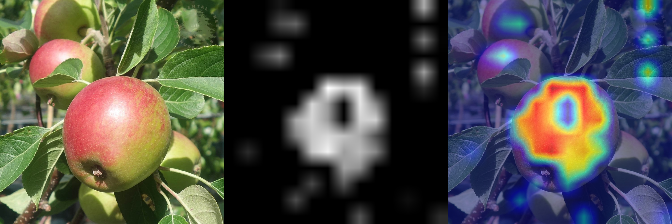

In [14]:
# Which target_layer should we chose for Swin Transformers?
# Since the swin transformer is different from ViT, it does not contains cls_token as present in ViT, 
# therefore we will use all the 7x7 images we get from the last block of the last layer.
# We should chose any layer before the final attention block
# SwinT: model.layers[-1].blocks[-1].norm1

#for vit16
target_layers = model.encoder.layers.encoder_layer_10.mlp #features,  (7): Sequential  (0): SwinTransformerBlock  (norm1)

# for swin_t:
#target_layers = [model.features[-1][-1].norm2]  #features,  (7): Sequential  (0): SwinTransformerBlock  (norm1)


targets = [ClassifierOutputTarget(3)]


with GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets) #switched to None as in example: https://github.com/jacobgil/pytorch-grad-cam/blob/master/usage_examples/swinT_example.py
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)


cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)
